In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv
import ipaddress
import os

from dotenv import load_dotenv
from scapy.all import PcapReader, IP, TCP, UDP, ICMP
from scipy.stats import ttest_ind, kstest, norm, skew, kurtosis, zscore
from summarytools import dfSummary
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import PandasAI

# scikit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# scikit llm imports
from skllm.config import SKLLMConfig
from skllm import (
    ZeroShotGPTClassifier,
    FewShotGPTClassifier,
    DynamicFewShotGPTClassifier,
)

In [2]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")

In [3]:
pcap_reader_mirai = PcapReader("data/mirai.pcap")
pcap_reader_benign = PcapReader("data/benign.pcapng")

# Preprocess

- convert data to streams
- collect some numbers

In [4]:
def pcap_to_dataframe(pcap_reader: PcapReader) -> pd.DataFrame:
    """Converts a packet capture to a Pandas DataFrame.

    Args:
        pcap_reader (PcapReader): packet capture read using scapy

    Returns:
        pd.DataFrame: dataframe with pcap data
    """
    # Create an empty list to store the data
    data = []

    # Iterate through the packets in the pcap file
    for packet in pcap_reader:
        # Get the source and destination IP addresses
        if packet.haslayer(IP):
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
        else:
            src_ip = None
            dst_ip = None

            protocol = None

        # Get the source and destination ports and payload
        if packet.haslayer(TCP):
            src_port = packet[TCP].sport
            dst_port = packet[TCP].dport
            payload = str(packet[TCP].payload)
            packet_len = len(packet[TCP])
        elif packet.haslayer(UDP):
            src_port = packet[UDP].sport
            dst_port = packet[UDP].dport
            payload = str(packet[UDP].payload)
            packet_len = len(packet[UDP])
        elif packet.haslayer(ICMP):
            payload = str(packet[ICMP].payload)
            packet_len = len(packet[ICMP])
            src_port = None
            dst_port = None
        else:
            src_port = None
            dst_port = None
            payload = str(packet.payload)
            packet_len = len(packet)

        # Append the data to the list
        data.append(
            [
                packet.time,
                src_ip,
                dst_ip,
                src_port,
                dst_port,
                payload,
                packet_len,
                protocol,
            ]
        )

    # Convert the list to a pandas dataframe
    df = pd.DataFrame(
        data,
        columns=[
            "Timestamp",
            "Source IP",
            "Destination IP",
            "Source Port",
            "Destination Port",
            "Payload",
            "Packet Length",
            "Protocol",
        ],
    )

    return df

In [ ]:
# mirai_df = pcap_to_dataframe(pcap_reader_mirai)
# benign_df = pcap_to_dataframe(pcap_reader_benign)

In [5]:
# mirai_df.to_pickle("../data/bsides_aug/mirai.pkl")
# benign_df.to_pickle("../data/bsides_aug/benign.pkl")

In [6]:
mirai_df = pd.read_pickle("data/mirai.pkl")
benign_df = pd.read_pickle("data/benign.pkl")

In [ ]:
mirai_df

In [ ]:
benign_df

## AI
Use pandas AI to clean up the data

In [7]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)
pandas_ai = PandasAI(llm)

In [8]:
mirai_cleaned_df = pandas_ai.run(mirai_df, prompt="Copy the dataframe to a new variable named df_cleaned. Do data cleaning. Return df_cleaned.")

In [33]:
benign_clean_df = pandas_ai.clean_data(benign_df)

In [9]:
# TODO: run late night to get result
mirai_cleaned_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,NaT,192.168.2.113,42.99.254.162,59650.0,80.0,,40,6
1,NaT,192.168.2.1,192.168.2.113,NaN,NaN,IPerror / TCPerror,68,1
2,NaT,192.168.2.113,210.61.248.232,36060.0,80.0,,40,6
3,NaT,192.168.2.108,50.19.254.134,32761.0,10240.0,Raw,48,17
4,NaT,192.168.2.108,122.248.234.207,32761.0,10240.0,Raw,48,17
...,...,...,...,...,...,...,...,...
82217,NaT,192.168.2.1,192.168.2.109,NaN,NaN,"IPerror / UDPerror / DNS Qry ""b'time.windows.c...",70,1
82218,NaT,192.168.2.108,52.24.43.67,47157.0,80.0,Padding,26,6
82219,NaT,192.168.2.108,52.25.66.250,46453.0,8280.0,Padding,26,6
82220,NaT,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1


In [34]:
benign_clean_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,NaT,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0
1,NaT,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0
2,NaT,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0
3,NaT,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0
4,NaT,10.0.0.2,224.0.0.5,NaN,NaN,10.0.0.2 > 224.0.0.5 ospf / Raw,94,89.0
...,...,...,...,...,...,...,...,...
23051,NaT,194.247.5.27,194.247.5.1,1812.0,10048.0,Radius,40,17.0
23052,NaT,194.247.5.1,194.247.5.27,3860.0,1812.0,Radius,112,17.0
23053,NaT,194.247.5.27,194.247.5.1,1812.0,3860.0,Radius,104,17.0
23054,NaT,194.247.5.1,194.247.5.27,3373.0,1812.0,Radius,120,17.0


In [10]:
# mirai_cleaned_df.to_pickle("data/mirai_cleaned.pkl")
# benign_clean_df.to_pickle("data/benign_cleaned.pkl")

In [ ]:
mirai_cleaned_df = pd.read_pickle("data/mirai_cleaned.pkl")
benign_clean_df = pd.read_pickle("data/benign_cleaned.pkl")

## Extract streams
Extract streams using the tuple (src_IP, src_port, dst_ip, dst_port, protocol).

In [11]:
def extract_streams(df: pd.DataFrame) -> pd.DataFrame:
    # Create an empty list to store stream data as separate dataframes
    dfs = []

    # Group packets by src/dst IP and src/dst port
    grouped = df.groupby(
        ["Source IP", "Destination IP", "Source Port", "Destination Port", "Protocol"]
    )

    # Iterate through each group to extract stream data
    for name, group in grouped:
        # Get source/destination IP, port, and protocol
        src_ip, dst_ip, src_port, dst_port, proto = name

        # Get number of packets, total length, and duration of the stream
        num_packets = len(group)
        total_length = group["Packet Length"].sum()
        start_time = group["Timestamp"].min()
        end_time = group["Timestamp"].max()
        duration = float(end_time - start_time)

        # Create a new dataframe with the stream data
        stream_df = pd.DataFrame(
            {
                "Source IP": [src_ip],
                "Destination IP": [dst_ip],
                "Source Port": [src_port],
                "Destination Port": [dst_port],
                "Protocol": [proto],
                "Number of Packets": [num_packets],
                "Total Length": [total_length],
                "Duration": [duration],
            }
        )

        # Add the new dataframe to the list
        dfs.append(stream_df)

    # Concatenate all the dataframes in the list into one dataframe
    stream_df = pd.concat(dfs, ignore_index=True)

    # Return the new dataframe with stream data
    return stream_df

In [12]:
# TODO: find whi timestamp is gone in the cleaned dataframes and use cleaned dataframes here
mirai_stream_df = extract_streams(mirai_df)
benign_stream_df = extract_streams(benign_df)

# EDA

Exploratory Data Analysis approaches the dataset as a black box that we need to visualize and analyze statistically with the following goals:
- get insights about our data
- test hypotheses
- decide on models and further processing, such as feature engineering.

EDA can be performed for benign and malicious data. Here we are looking at EDA only for malicious data, however the same functions can be applied to benign.

## Descriptive statistics & data

- Describe columns and data types
- Descriptive statistics
  -  count, 
  -  mean, 
  -  standard deviation, 
  -  minimum, 
  -  25th percentile, 
  -  median (50th percentile), 
  -  75th percentile, and 
  -  maximum

In [13]:
# describe, summarize etc.
mirai_stream_df.columns

Index(['Source IP', 'Destination IP', 'Source Port', 'Destination Port',
       'Protocol', 'Number of Packets', 'Total Length', 'Duration'],
      dtype='object')

In [14]:
mirai_stream_df.dtypes

Source IP             object
Destination IP        object
Source Port          float64
Destination Port     float64
Protocol             float64
Number of Packets      int64
Total Length           int64
Duration             float64
dtype: object

In [15]:
# descriptive statistics
mirai_stream_df.describe()

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration
count,14138.000000,14138.000000,14138.000000,14138.000000,14138.000000,14138.000000
mean,32980.104895,2152.375088,13.219479,4.705687,199.615009,14.185579
std,21650.445270,6092.466512,5.224492,72.311029,3057.301765,153.306208
min,0.000000,23.000000,6.000000,1.000000,26.000000,0.000000
25%,3206.250000,53.000000,6.000000,1.000000,40.000000,0.000000
50%,40048.500000,53.000000,17.000000,1.000000,74.000000,0.000000
75%,51555.000000,443.000000,17.000000,3.000000,104.000000,2.850280
max,64633.000000,63749.000000,17.000000,2862.000000,135840.000000,2571.501515


In [16]:
# correlation matrix for numerical values in dataframe
mirai_stream_df.corr()

/tmp/ipykernel_40362/1430202552.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mirai_stream_df.corr()


,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration
Source Port,1.000000,-0.135555,-0.311714,-0.013628,-0.012811,-0.016093
Destination Port,-0.135555,1.000000,-0.214269,0.057033,0.057138,0.063952
Protocol,-0.311714,-0.214269,1.000000,-0.013221,0.005097,0.005727
Number of Packets,-0.013628,0.057033,-0.013221,1.000000,0.959277,0.620179
Total Length,-0.012811,0.057138,0.005097,0.959277,1.000000,0.603591
Duration,-0.016093,0.063952,0.005727,0.620179,0.603591,1.000000


## Hypothesis testing

- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [17]:
def hypothesis_testing(df, col1, col2):
    group1 = df[col1]
    group2 = df[col2]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between {} and {} is statistically significant (p < 0.05)".format(
            col1, col2
        )
    else:
        return "The difference between {} and {} is not statistically significant (p >= 0.05)".format(
            col1, col2
        )

In [18]:
hypothesis_testing(mirai_stream_df, "Number of Packets", "Total Length")

'The difference between Number of Packets and Total Length is statistically significant (p < 0.05)'

## Outliers

- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [19]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [20]:
outliers = detect_outliers_zscore(mirai_stream_df, "Total Length", threshold=3)
print(outliers)

           Source IP   Destination IP  Source Port  Destination Port  \
1        192.168.2.1    192.168.2.110         23.0           21897.0   
1611     192.168.2.1  239.255.255.250       1900.0            1900.0   
1613   192.168.2.101    192.168.2.110         23.0           21897.0   
1624   192.168.2.103    192.168.2.110         23.0           21897.0   
2083   192.168.2.107    192.168.2.110         23.0           21897.0   
2087   192.168.2.108   122.226.84.253      32761.0           10240.0   
2088   192.168.2.108  122.248.234.207      32761.0           10240.0   
2089   192.168.2.108    46.137.188.54      32761.0           10240.0   
2090   192.168.2.108    50.19.254.134      32761.0           10240.0   
3225   192.168.2.108    61.188.37.216      32761.0           10240.0   
6219   192.168.2.110      192.168.2.1      21897.0              23.0   
6884   192.168.2.110    192.168.2.101      21897.0              23.0   
6887   192.168.2.110    192.168.2.103      21897.0              

## AI
Explore the data with AI

In [21]:
top_5_source_IPs = pandas_ai(
    mirai_df, prompt="Which are the 5 most popular source IP addresses?"
)
top_5_source_IPs

'Source IP\n192.168.2.108    18726\n192.168.2.110    14341\n192.168.2.1      13719\n192.168.2.113    12491\n192.168.2.115     4859\nName: Source IP, dtype: int64'

In [22]:
top_5_dst_ports = pandas_ai(
    mirai_df, prompt="Which are the 5 most popular destination ports?"
)
top_5_dst_ports

'Destination Port\n10240.0    22486\n53.0       12078\n23.0        9085\n21897.0     7158\n80.0        6429\ndtype: int64'

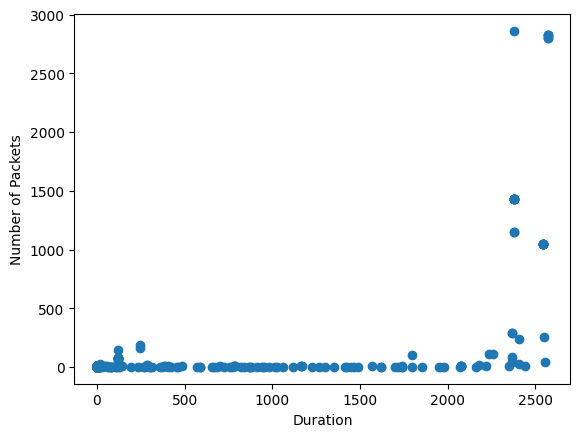

"<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 14138 entries, 0 to 14137\nData columns (total 8 columns):\n #   Column             Non-Null Count  Dtype  \n---  ------             --------------  -----  \n 0   Source IP          14138 non-null  object \n 1   Destination IP     14138 non-null  object \n 2   Source Port        14138 non-null  float64\n 3   Destination Port   14138 non-null  float64\n 4   Protocol           14138 non-null  float64\n 5   Number of Packets  14138 non-null  int64  \n 6   Total Length       14138 non-null  int64  \n 7   Duration           14138 non-null  float64\ndtypes: float64(4), int64(2), object(2)\nmemory usage: 883.8+ KB\nNone"

In [23]:
pandas_ai.run(
    mirai_stream_df,
    prompt="Plot the scatter plot of stream durations and number of packets.",
)

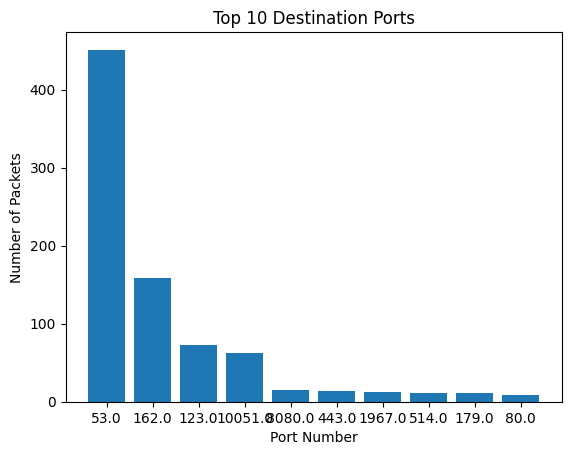

In [24]:
pandas_ai.run(benign_stream_df, prompt="Plot a barplot of top 10 destination ports.")

# Feature Engineering

## Numerical

In [25]:
# convert ip address to numeric values
def ip_to_numeric(ip):
    ip_obj = ipaddress.ip_interface(ip)
    return int(ip_obj.network.network_address)

In [26]:
# convert IPs to numeric mirai data
mirai_stream_df["Source IP Numeric"] = mirai_stream_df["Source IP"].apply(ip_to_numeric)
mirai_stream_df["Destination IP Numeric"] = mirai_stream_df["Destination IP"].apply(
    ip_to_numeric
)

In [27]:
# convert IPs to numeric benign data
benign_stream_df["Source IP Numeric"] = benign_stream_df["Source IP"].apply(
    ip_to_numeric
)
benign_stream_df["Destination IP Numeric"] = benign_stream_df["Destination IP"].apply(
    ip_to_numeric
)

In [28]:
# get rid of non numeric columns for IPs
mirai_stream_df_numeric = mirai_stream_df.drop(columns=["Source IP", "Destination IP"])
benign_stream_df_numeric = benign_stream_df.drop(
    columns=["Source IP", "Destination IP"]
)

In [29]:
# convert duration from object to float
mirai_stream_df["Duration"] = mirai_stream_df_numeric["Duration"].astype(float)
benign_stream_df["Duration"] = benign_stream_df_numeric["Duration"].astype(float)

In [30]:
# check if all data types are numeric now
mirai_stream_df_numeric.dtypes

Source Port               float64
Destination Port          float64
Protocol                  float64
Number of Packets           int64
Total Length                int64
Duration                  float64
Source IP Numeric           int64
Destination IP Numeric      int64
dtype: object

## AI
Generate features using `generate_features` from `pandas_ai` on cleaned up data or subset of original due to long requests.

In [31]:
pandas_ai.generate_features(mirai_cleaned_df)

,Hour,Minute,Second,Source_IP,Destination_IP,Source_Port,Destination_Port,Packet Length,Protocol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,6
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,17
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,17
...,...,...,...,...,...,...,...,...,...
82217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,1
82218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,6
82219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,6
82220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,1


In [35]:
pandas_ai.generate_features(benign_clean_df)

,Hour,Minute,Second,Source_IP,Destination_IP,Source_Port,Destination_Port,Packet Length,Protocol
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,17.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,17.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,17.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,17.0
4,NaN,NaN,NaN,10.0.0.2,NaN,NaN,NaN,94,89.0
...,...,...,...,...,...,...,...,...,...
23051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,17.0
23052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112,17.0
23053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,17.0
23054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,17.0


# Summaries & Visualizations

In [36]:
skim(mirai_stream_df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14138  │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃    ┃      ┃            ┃            ┃           ┃           ┃            ┃           ┃        ┃  │
│ ┃ e          ┃ NA ┃ NA % ┃ mean       ┃ sd         ┃ p0        ┃ p25       ┃ p75        ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Source     │  0 │    0 │      33000 │      22000 │         0 │      3200 │      52000 │     65000 │ █▁▁▇▇▅ │  │
│ │ Port       │    │      │            │            │           │           │            │           │        │  │
│ │ Destinatio │  0 │    0 │       2200 │       6100 │        23 │        53 │        440 │     64000 │   █    │  │
│ │ n Port     │    │      │            │            │           │           │            │           │        │  │
│ │ Protocol   │  0 │    0 │         13 │        5.2 │         6 │         6 │         17 │        17 │ ▄    █ │  │
│ │ Number of  │  0 │    0 │        4.7 │         72 │         1 │         1 │          3 │      2900 │   █    │  │
│ │ Packets    │    │      │            │            │           │           │            │           │        │  │
│ │ Total      │  0 │    0 │        200 │       3100 │        26 │        40 │        100 │    140000 │   █    │  │
│ │ Length     │    │      │            │            │           │           │            │           │        │  │
│ │ Duration   │  0 │    0 │         14 │        150 │         0 │         0 │        2.9 │      2600 │   █    │  │
│ │ Source IP  │  0 │    0 │ 3200000000 │   27000000 │         0 │ 320000000 │ 3200000000 │ 320000000 │      █ │  │
│ │ Numeric    │    │      │            │            │           │         0 │            │         0 │        │  │
│ │ Destinatio │  0 │    0 │ 2200000000 │ 1100000000 │ 130000000 │ 100000000 │ 3200000000 │ 430000000 │ ▂▃▃ █  │  │
│ │ n IP Numer │    │      │            │            │           │         0 │            │         0 │        │  │
│ └────────────┴────┴──────┴────────────┴────────────┴───────────┴───────────┴────────────┴───────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [37]:
skim(benign_stream_df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1689   │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃    ┃      ┃            ┃            ┃          ┃            ┃            ┃           ┃        ┃  │
│ ┃ e          ┃ NA ┃ NA % ┃ mean       ┃ sd         ┃ p0       ┃ p25        ┃ p75        ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Source     │  0 │    0 │      27000 │      24000 │        7 │         53 │      50000 │     66000 │ █  ▃▄▂ │  │
│ │ Port       │    │      │            │            │          │            │            │           │        │  │
│ │ Destinatio │  0 │    0 │      21000 │      23000 │        7 │         53 │      43000 │     66000 │ █  ▃▂▂ │  │
│ │ n Port     │    │      │            │            │          │            │            │           │        │  │
│ │ Protocol   │  0 │    0 │         15 │        6.1 │        6 │         17 │         17 │        47 │   ▂█   │  │
│ │ Number of  │  0 │    0 │         11 │        110 │        1 │          1 │          5 │      3400 │   █    │  │
│ │ Packets    │    │      │            │            │          │            │            │           │        │  │
│ │ Total      │  0 │    0 │       3300 │      66000 │       26 │         60 │        480 │   2600000 │   █    │  │
│ │ Length     │    │      │            │            │          │            │            │           │        │  │
│ │ Duration   │  0 │    0 │     100000 │    4300000 │        0 │          0 │     0.0027 │ 180000000 │   █    │  │
│ │ Source IP  │  0 │    0 │ 2400000000 │ 1300000000 │        0 │ 1400000000 │ 3200000000 │ 360000000 │ ▂ ▁  █ │  │
│ │ Numeric    │    │      │            │            │          │            │            │         0 │        │  │
│ │ Destinatio │  0 │    0 │ 2300000000 │ 1400000000 │ 17000000 │ 1100000000 │ 3200000000 │ 430000000 │ ▃▁  █  │  │
│ │ n IP Numer │    │      │            │            │          │            │            │         0 │        │  │
│ └────────────┴────┴──────┴────────────┴────────────┴──────────┴────────────┴────────────┴───────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [38]:
dfSummary(mirai_stream_df_numeric)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Source Port[float64],Mean (sd) : 32980.1 (21650.4)min < med < max:0.0 < 40048.5 < 64633.0IQR (CV) : 48348.8 (1.5),"10,709 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnUlEQVR4nO3cv27aUBiG8e9AAPNHRggVNpaOlTp45CJ6sb2EDFwBQ5dObEgIgXCDMIYOVbpUCvgcO/hNn9+cY0fRk5NYHH/uer0aUHeNR38DwD2ebn2Bc65rZm3P65+u1+uL51rgrzdDdc51x+PxtziORz4X3+/3W+fcd2JFqFs7ajuO49F8Pn8ZDofHIhfe7XbRYrEYbTabtpkRKoLc/NNvZjYcDo+TyeSXx/W7HmuAf/AwBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgl3DaDA/yFwzphZhbPGCBVmFj5nzKzaWWOEWgHRCYjec8bMqp81RqglU5+AGDBnzKzCWWOEWr6HTkAM2M3jy+XS8rnneyDUijxiAmLIbp5lWZTn+Zfj8fhsZr47amUItWbyPG+ZWeyc81keDwaDyXw+3xfdzVer1Wi5XPbO53PT58ZVI9QaSdO0lWXZ19ls1mw2m4UfaF53xU6n81x0N99ut7WeZUuoNXI6nZ6iKOolSXKcTqfbouvrviuGINQa6vf7Xv/f1n1XDMFHqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJDAoRSUJvAs7ZvvihEqShF6lvbWu2KEilKEnKW9510xQkWpfM/S2o13xXiYggRChQRChQRChQRChQRChQRChQRChQRChQRChYRKP0INPE1j9ucX6fKAtSHraz1nVFVloYaepsnzvJWm6efBYPCz0Whk77U2dH3d54yqqizUkibTfUqS5EfR9SFrS7r3h5yo90h3hbrb7aKiFz4cDoXXfCRpmkbr9bpXZM3rz8xnbej6R977nr5+A4RBTvroNwveAAAAAElFTkSuQmCC"">",0(0.0%)
2,Destination Port[float64],Mean (sd) : 2152.4 (6092.5)min < med < max:23.0 < 53.0 < 63749.0IQR (CV) : 390.0 (0.4),"1,643 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACF0lEQVR4nO3YQW7aUBRG4XsLIXZAtpAbM2MJDBiyiCw2i/CUfSBZ6Fk4JlDLnXVStcQmKPzt+cbcqzc44snPu64z4N59++oDAB8xvvQDd4/NbDJw/6nrumbgLPDLX0N19zjLspckSeZDlldVtXf3V2LFtS79o06SJJlvNpsmTdNjn8UhhKgoinlZlhMzI1Rc5eLVb2aWpukxz/O3AfvjATPAb/iYggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYTxLZe3bftgZom7D11x6rqu+cQjQdTNQq3r+uF8Pq+Wy+VoNBodh+yoqmrv7q/EipuFejqdxlEUPa3X6+Nisdj3nQ8hREVRzMuynJgZof7nbnr1m5lNp9NjnudvA8fjTz0MZPExBQmECgk3v/q/irvHZja5YgUvDnfknwzV3eMsy16SJJkP3cGLw335UKghhKjv4sPhEJmZ1XUd7Xa7p77zIYSobduxDXuHTWaz2fNqtfoRx/F73+GmaR632+1zWZbf3b3qO49B3ruu++Mz5k/C7nnoEMc9CgAAAABJRU5ErkJggg=="">",0(0.0%)
3,Protocol[float64],1. 17.02. 6.0,"9,279 (65.6%)4,859 (34.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOklEQVR4nO3bMWrDQBRF0a8gTNzMIARajBaRxWYRsxshNEVs3EwKF8GkNW+cl3tW8I0vAhu9obUWgMIQEeeIOPU+BL/cWmuX3kc80zjP80dKaep9CB7VWvdhGD6dghtTStO6rpec87X3Mbg7juO9lDJt23aKCJ/YIiJyztdlWb56H4MH594HPNtb7wPwfxAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CAzRtxf1ut9CH64fh9jrXUvpUxh+LLeX1Zr3SPi1vuOZ2Lw8rrsBi8DUz6ouD7Z7J4KDiynfI4zOAd2Uz7XGZwD1ykfv6xfEH/qQobYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZuymf02dxYznlc5zBOWDwAplvCltq30b8rewAAAAASUVORK5CYII="">",0(0.0%)
4,Number of Packets[int64],Mean (sd) : 4.7 (72.3)min < med < max:1.0 < 1.0 < 2862.0IQR (CV) : 2.0 (0.1),39 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABaUlEQVR4nO3XT2oCMRiH4aSI6GYGETyMh+hhewhvIyUuqi1Iuuum1D/jov3R59km+cjiZYbU3nuBv+7pty8At5hd21BrXZZS5hPnf/TejxPPwpeLodZal+v1+nkYhtWU4YfD4bXW+iJWHnXtizofhmG13W6P4zie7hncWlvsdrvVfr+fl1KEykOu/vpLKWUcx9Nms3mbMH854Qx84zFFBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEmN2yqbW2uHdwa21xPp9npZSh1nr3xfh33nvvp58WPwF79y3yrjldnwAAAABJR

In [39]:
dfSummary(benign_stream_df_numeric)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Source Port[float64],Mean (sd) : 26659.7 (24067.5)min < med < max:7.0 < 34492.0 < 65535.0IQR (CV) : 49819.0 (1.1),960 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACr0lEQVR4nO3dMW/aQByG8f9BiEyCbEFU2LJ0rNSBMXvXfth+hA4ZMmfo0okNgZCjuEE4B12aLlUDvuOEX/T8Zs620CMO+yyd2+12BrRd59QXABziYt8HnHN9M7sMPP5mt9u9BI4F/no3VOdc/+bm5mue58OQgz89Pa2cc9+IFbH2/aJe5nk+vLu7eymKYt3kwGVZZvf398PlcnlpZoSKKHunfjOzoijW4/H4V8Dx+wFjgH9wMwUJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJB+3cBx2Rmyx3zGwbcfpkmzQT6hmJ2WTZe9+rqurjYDD42el06pDzp9ykmVDPS/Amy7PZbPj4+PhhOp3+mEwmq6YnTr1JM6EmEDn9Rk+fIZssr1arvpnZ9fV16AbNZgk3aSbUI4uZfs3STp/KCPX4gqff1NOnMkJNJGT6NTPz3udmljvnQk6bb7fbXsjAtiPUFqmqqlfX9efb29tut9tt9GtsZlbXdea9/7Rer7+bWej/zFYi1BbZbDYXWZZdTafTdcid958796vX19duius7JUJtodA777c793PEEiokECokMPXjaLz3PQt/YvHuQkfSUCMv3CzhSw44rtgnFvsWOpKFGnvhZqzSKIl5YnHIQkeyUGMftbBKoyniXYF3n1gk/4/a1pccoIW7fkggVEggVEggVEjggf9/RLylf7av2p3SQaGWZZk1PfDz83NmZlZVVTafz6+aji/LMvPeX1jcgkGobDQafSmKYtB04NurdovF4qHp2NjvLGb8Kc99SF+/ASOpMUV6e6uTAAAAAElFTkSuQmCC"">",0(0.0%)
2,Destination Port[float64],Mean (sd) : 20701.5 (23372.0)min < med < max:7.0 < 3385.0 < 65535.0IQR (CV) : 43293.0 (0.9),741 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACv0lEQVR4nO3dT27aQBSA8TeFkOGPZuQQOTsuEKmLSNn4AF3msDlCFyyyzg2yi4SQrRAQjuMu2qatKgGewYJHvt+aGSz06cHYC0xd1wIcuy+HvgBgF91tLzDG9EWkF7j/uq7rZeBa4MPGUI0x/fF4fOecS0I2L4piboy5J1bE2jZRe865JMuypfd+1WTjPM/tdDpNZrNZT0QIFVG2fvWLiHjvV2mavgbs3w9YA/yHwxRUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKO/0NOpoxxvRFpBe4fF3X9XKf13MKCHXPjDH98Xh855xLQtYXRTE3xtwT678Idf96zrkky7Kl937VZGGe53Y6nSaz2awnIoT6F0Jtifd+labpa8DS/t4v5gRwmIIKTFR8iDwEirR4ECTUExMRm724uPjmvR+GvnebB0FCPSExdxzKsrQicn17e/tweXlZNF3f9kGQUI9MVVVnIuKMMSHL3Wg0SrMsK5recXh6ekoeHx8H1toy8BAo0uJBkFCPyGKxOCvL8utkMul0Op1GoYn8nIpVVV2fn59/bxrbfD4/6rsNrYYaOR1EPtlTmvV63bXWDm5ublZXV1fzput/T8W3t7dOG9d3SK2FGjsdRD7vU5rhcBh0D/bQUzFyMG0cSq2FGjsdeEqjS+xg2jaUWv+NGjodfjnq3034I2Yw7TKUOExhryIG08ahxCNUqECoUGGnr/48z23TjV9eXqyIyGKxsM/Pz4Om6/M8t1VVdSXu9tYhuPf39+4hPrOY9Yd8710+qx9gGxyBLIEUEgAAAABJRU5ErkJggg=="">",0(0.0%)
3,Protocol[float64],1. 17.02. 6.03. 41.04. 47.0,"1,272 (75.3%)378 (22.4%)35 (2.1%)4 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACBklEQVR4nO3bQW7TUBSG0esoKnTiKIrUJcAevAgWyyKyCPYQRfGAlE7MoAVBxATh/H4y58wyu1I+2XnRu900TQUJm6UH4P8hNmK6qnqsqoelB2FWL9M0XZce4tb2cDh86vt+v/QgzGccx3PXdZ9bC27b9/1+GIbrbrd7XnoY/t3lcnl/PB73p9Ppoaraiq2qarfbPT89PX1dehhm87j0AH/igECM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxGyrXq+lLD0I82j5u9yO43g+Ho/7avRaCn9vHMdzVb0sPcct18LXqclr4Z1VPlIcEIhp7TXa5OOfeTS1XdXqVhDzaGa7quWtIObR2naVv19WzAGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzHNrPK1MAP31dQqX6sraMzDDgIxVvmIuX2yebJwN79tV9lu4p42P7arhmG4vkXXyu83VubndtXb58VPpKyXP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEdPMdhXr9+t2le0m7soOAjG2q4hxQCBm03Xdx67rHBC4u01Vfaiqd0sPwvp5jRIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YTVV9qapvSw/C+ll4IcZrlBixEfMd6iScShhmFWYAAAAASUVORK5CYII="">",0(0.0%)
4,Number of Packets[int64],Mean (sd) : 11.0 (105.4)min < med < max:1.0 < 1.0 < 3368.0IQR (CV) : 4.0 (0.1),67 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bG

In [ ]:
my_report = sv.analyze(mirai_stream_df_numeric)
my_report.show_html(filepath="html/mirai_stream.html")

In [ ]:
my_report = sv.analyze(benign_stream_df_numeric)
my_report.show_html(filepath="html/benign_stream.html")

# Labeling
We label and concatenate benign and malicious before one-hot because there are different ports in each dataset and concatenating the two after one hot will not work with different columns.

In [ ]:
# add labels, 0 for benign, 1 for malicious
mirai_stream_df_numeric["Labels"] = 1
benign_stream_df_numeric["Labels"] = 0

In [43]:
# concatenate dataframes
data_df = pd.concat(
    [mirai_stream_df_numeric, benign_stream_df_numeric], ignore_index=True
)

# Feature engineering (cont.) categorical 
## One-hot

In [44]:
def one_hot_encode(df, feature):
    feature_dummies = pd.get_dummies(df[feature], prefix=feature)
    return pd.concat([df, feature_dummies], axis=1)

Opening in existing browser session.


In [45]:
data_df = one_hot_encode(data_df, "Source Port")
data_df = one_hot_encode(data_df, "Destination Port")

# Model Training
- models
  - xgboost
  - NN
  - k-NN
  - Random Forest
- k-fold cross validation

In [46]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

In [47]:
# randomize the data. TODO: is this needed??
data_df = shuffle(data_df)

In [48]:
# after feature engineering, drop all the columns that are unnecessary
data_df = data_df.drop(["Source Port", "Destination Port"], axis=1)

In [49]:
# store the features and labels in separate dataframes
X = data_df.drop("Labels", axis=1)
y = data_df["Labels"]

In [50]:
# convert data to array
data_array = data_df.to_numpy()

In [51]:
model = 1
for train, test in kfold.split(data_array):
    print(f"Model {model}")
    print(f"train {train}, test: {test}")
    model += 1

Model 1
train [    0     1     2 ... 15824 15825 15826], test: [    4     5     6 ... 15815 15820 15823]
Model 2
train [    0     1     2 ... 15823 15824 15825], test: [    7    12    16 ... 15811 15817 15826]
Model 3
train [    0     2     4 ... 15824 15825 15826], test: [    1     3    10 ... 15812 15818 15821]
Model 4
train [    0     1     2 ... 15823 15824 15826], test: [    8     9    13 ... 15816 15822 15825]
Model 5
train [    1     3     4 ... 15823 15825 15826], test: [    0     2    15 ... 15806 15819 15824]


In [52]:
# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=3)

In [53]:
# Random Forest Classifier
rf_model = RandomForestClassifier(max_depth=2, random_state=0)

In [54]:
# XGBoost
xgb_model = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)

In [55]:
def k_fold_model(model, X, y):
    accuracy_scores = []
    for train, test in kfold.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train)

        # evaluate model accuracy
        accuracy = model.score(X_test, y_test)
        accuracy_scores.append(accuracy)

    return accuracy_scores

# Model Evaluation

## Accuracy

Accuracy is the proportion of correct predictions to the total number of predictions.

In [56]:
# Calculate the average accuracy score across all folds
accuracy_scores = k_fold_model(knn_model, X, y)
average_accuracy = sum(accuracy_scores) / k
print("Average accuracy k-nn:", average_accuracy)

Average accuracy k-nn: 0.9745805653254503


In [57]:
# Calculate the average accuracy score across all folds
accuracy_scores = k_fold_model(rf_model, X, y)
average_accuracy = sum(accuracy_scores) / k
print("Average accuracy random forest:", average_accuracy)

Average accuracy random forest: 0.8932832754014564


In [58]:
# Calculate the average accuracy score across all folds
accuracy_scores = k_fold_model(xgb_model, X, y)
average_accuracy = sum(accuracy_scores) / k
print("Average accuracy XGBoost:", average_accuracy)

Average accuracy XGBoost: 0.9989259100693687


## Precision

Precision measures the proportion of true positives to the total predicted positives.

In [59]:
def model_evaluation(model, X, y, k, scorer):
    # Perform k-fold cross-validation and calculate precision scores
    model_scores = cross_val_score(model, X, y, cv=k, scoring=scorer)

    # Calculate the average score across all folds
    average_score = model_scores.mean()

    return average_score

In [60]:
# Assuming model is your trained model and X, y are the input features and labels respectively
# Set the scoring metric to precision
scorer = make_scorer(precision_score)

In [61]:
# TODO: how do we calculate precision for knn?
# print("Average Precision knn:", model_evaluation(knn_model, X, y, k, scorer))

In [62]:
print("Average Precision random forest:", model_evaluation(rf_model, X, y, k, scorer))

Average Precision random forest: 0.89328363466891


In [63]:
print("Average Precision xgboost", model_evaluation(xgb_model, X, y, k, scorer))

Average Precision xgboost 0.9989400541103126


## Recall

Recall (also known as sensitivity or true positive rate) measures the proportion of true positives to the total actual positives.

In [64]:
scorer = make_scorer(recall_score)

In [ ]:
print("Average Recall knn:", model_evaluation(knn_model, X, y, k, scorer))

In [66]:
print("Average Recall random forest:", model_evaluation(rf_model, X, y, k, scorer))

Average Recall random forest: 1.0


In [67]:
print("Average Recall xgboost:", model_evaluation(xgb_model, X, y, k, scorer))

Average Recall xgboost: 0.9998585572842998


## Confusion matrix

A confusion matrix is a table that visualizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [68]:
def plot_confusion_matrix(model, X, y):
    for train, test in kfold.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)

        # Create a heatmap of the confusion matrix
        sns.heatmap(cm, annot=True, cmap="Blues")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.show()

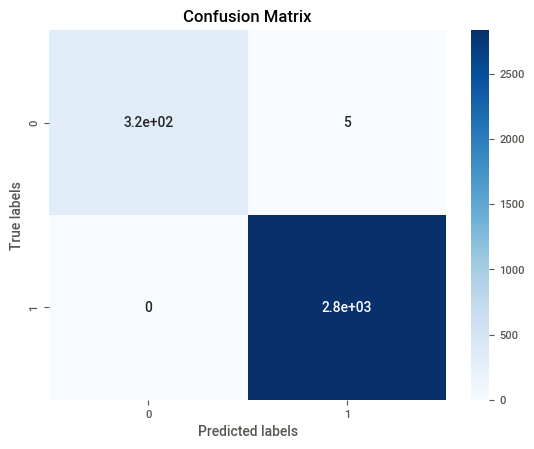

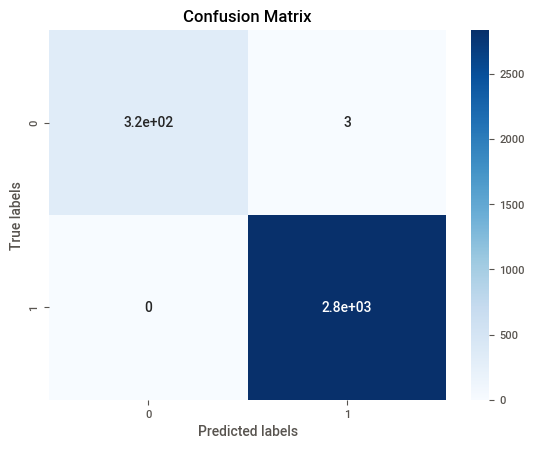

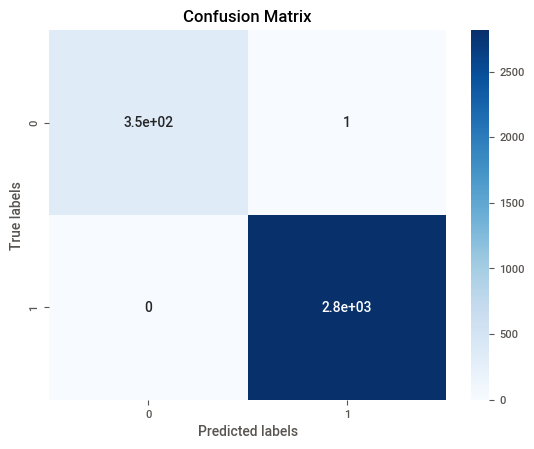

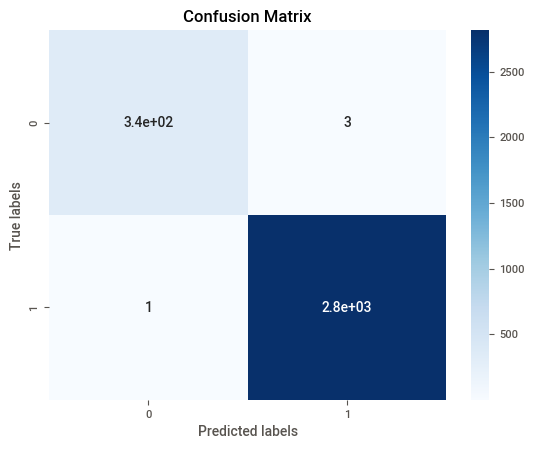

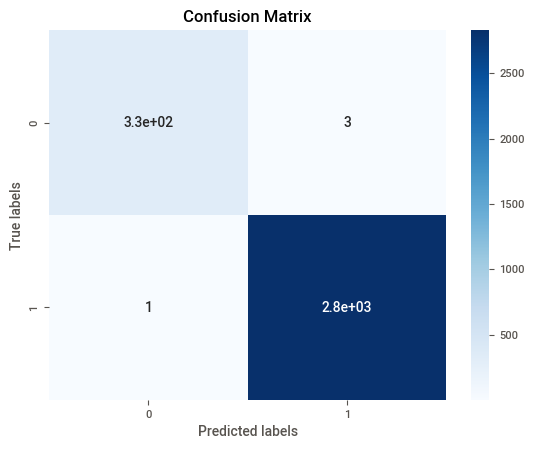

In [69]:
plot_confusion_matrix(xgb_model, X, y)

## ROC curve

Use pandas ai ROC curve

In [70]:
def split_data(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    # return X_test, y_test, y_pred
    return y_test, y_score

In [71]:
# X_test, y_test, y_pred = split_data(knn_model, X, y)

In [72]:
# ERROR: numpy.ndarrayThis model's maximum context length is 4097 tokens. 
# However, your messages resulted in 26146 tokens. Please reduce the length of the messages.
# pandas_ai.plot_roc_curve(X_test, y_test.tolist(), y_pred.tolist())

In [73]:
y_test, y_score = split_data(rf_model, X, y)

In [74]:
def plot_roc_curve(y_test, y_score):
    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")  # Random guessing line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

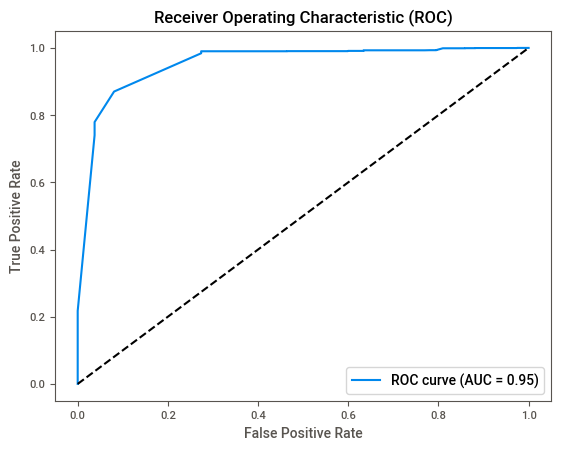

In [75]:
plot_roc_curve(y_test, y_score[:, 1])

In [76]:
y_test, y_score = split_data(xgb_model, X, y)

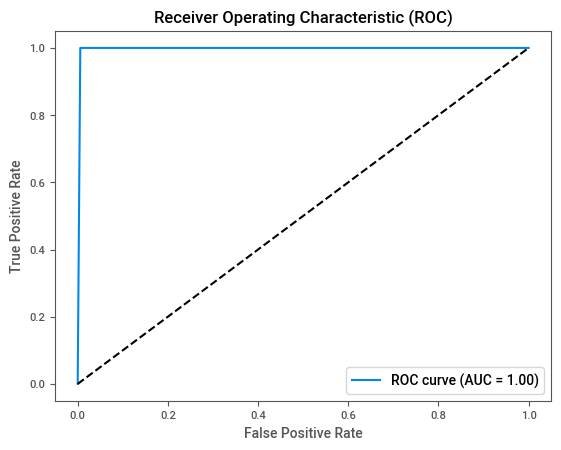

In [77]:
plot_roc_curve(y_test, y_score[:, 1])

# AI Classifier 
Use llm for classification. Can only use payload that is words.

In [78]:
# add labels, 0 for benign, 1 for malicious
mirai_cleaned_df["Labels"] = 1
benign_clean_df["Labels"] = 0

In [79]:
mirai_payloads = mirai_cleaned_df[["Payload", "Labels"]]
benign_payloads = benign_clean_df[["Payload", "Labels"]]

In [80]:
payloads = pd.concat([mirai_payloads, benign_payloads], ignore_index=True)

In [81]:
# TODO: use sample
payloads = shuffle(payloads)

In [82]:
# use a subset because this takes loooong!
X_llm = payloads["Payload"].head(20)
y_llm = payloads["Labels"].head(20)

In [83]:
y_llm.shape

(20,)

In [84]:
SKLLMConfig.set_openai_key(openai_api_key)
SKLLMConfig.set_openai_org("org-HlcxSARQUphcO0tUGmtJJOpD")

In [85]:
# TODO: DynamicFewShotGPTClassifier errors out, why?
# def ai_classify(classifier, X, Y):
#     classifier.fit(X, y)
#     labels = classifier.predict(X)
#     return labels

In [86]:
clf = ZeroShotGPTClassifier(openai_model="gpt-3.5-turbo")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

100%|██████████| 20/20 [00:44<00:00,  2.23s/it]

Accuracy: 0.70


In [87]:
clf = FewShotGPTClassifier(openai_model="gpt-3.5-turbo")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


In [88]:
print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

Accuracy: 0.55
